In [38]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import cv2
from PIL import Image

import os
import time
import lrResnet

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,30)

In [39]:
class MultiscaleDataset(Dataset):
    def __init__(self, root, transform, LR_scale=2, HR_size=[224,224], keep_size=False):               
        self.image_list = []
        self.LR_scale = LR_scale
        
        self.transform = transform
        
        if keep_size == True: # DFD Requires same LR, HR size. (Interpolated LR)
            # Couldn't expect computation reduction.
            self.LR_transform = transforms.Compose([
                transforms.Resize(HR_size[0]//LR_scale),
                transforms.Resize(HR_size, interpolation=Image.BICUBIC)
            ])
        else:
            self.LR_transform = transforms.Resize(HR_size[0]//LR_scale)

        self.ToTensor = transforms.ToTensor()
        # self.Normalizer = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        
        class_dirs = os.listdir(root)
        
        for label, class_dir in enumerate(class_dirs):
            image_dirs = os.listdir(os.path.join(root,class_dir))
            for img_path in image_dirs:
                self.image_list.append([label, os.path.join(root, class_dir, img_path)])
                
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        label = self.image_list[index][0]
        img = Image.open(self.image_list[index][1])
        
        if self.transform != None:
            img = self.transform(img)
        
        HR = self.ToTensor(img)
        LR = self.ToTensor(self.LR_transform(img))
        
        # Exception handling for the grayscale images.
        if(HR.shape[0] == 1):
            HR = HR.repeat(3, 1, 1)
        if(LR.shape[0] == 1):
            LR = LR.repeat(3, 1, 1)
        #----------------------------------------------

        # HR = self.Normalizer(HR)
        # LR = self.Normalizer(LR)
        
        return LR, HR, label
    
def get_train_loader(root='/data/CIFAR10_RAW/train', LR_scale=2, HR_size=[32,32], batch_size=128, num_workers=8, keep_size=False):
    transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
    ])
    
    train_dataset = MultiscaleDataset(root, transform=transform, LR_scale=LR_scale, HR_size=HR_size, keep_size=keep_size)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return train_dataloader

def get_test_loader(root='/data/CIFAR10_RAW/test', LR_scale=2, HR_size=[32,32], batch_size=128, num_workers=8, keep_size=False):
    
    test_dataset = MultiscaleDataset(root, transform=None, LR_scale=LR_scale, HR_size=HR_size, keep_size=keep_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return test_dataloader

LR_scale = 2
train_loader = get_train_loader(LR_scale=LR_scale, batch_size=128, num_workers=8, keep_size=True)
test_loader = get_test_loader(LR_scale=LR_scale, batch_size=128, num_workers=8, keep_size=True)

torch.Size([128, 3, 32, 32]) torch.Size([128, 3, 32, 32]) torch.Size([128])


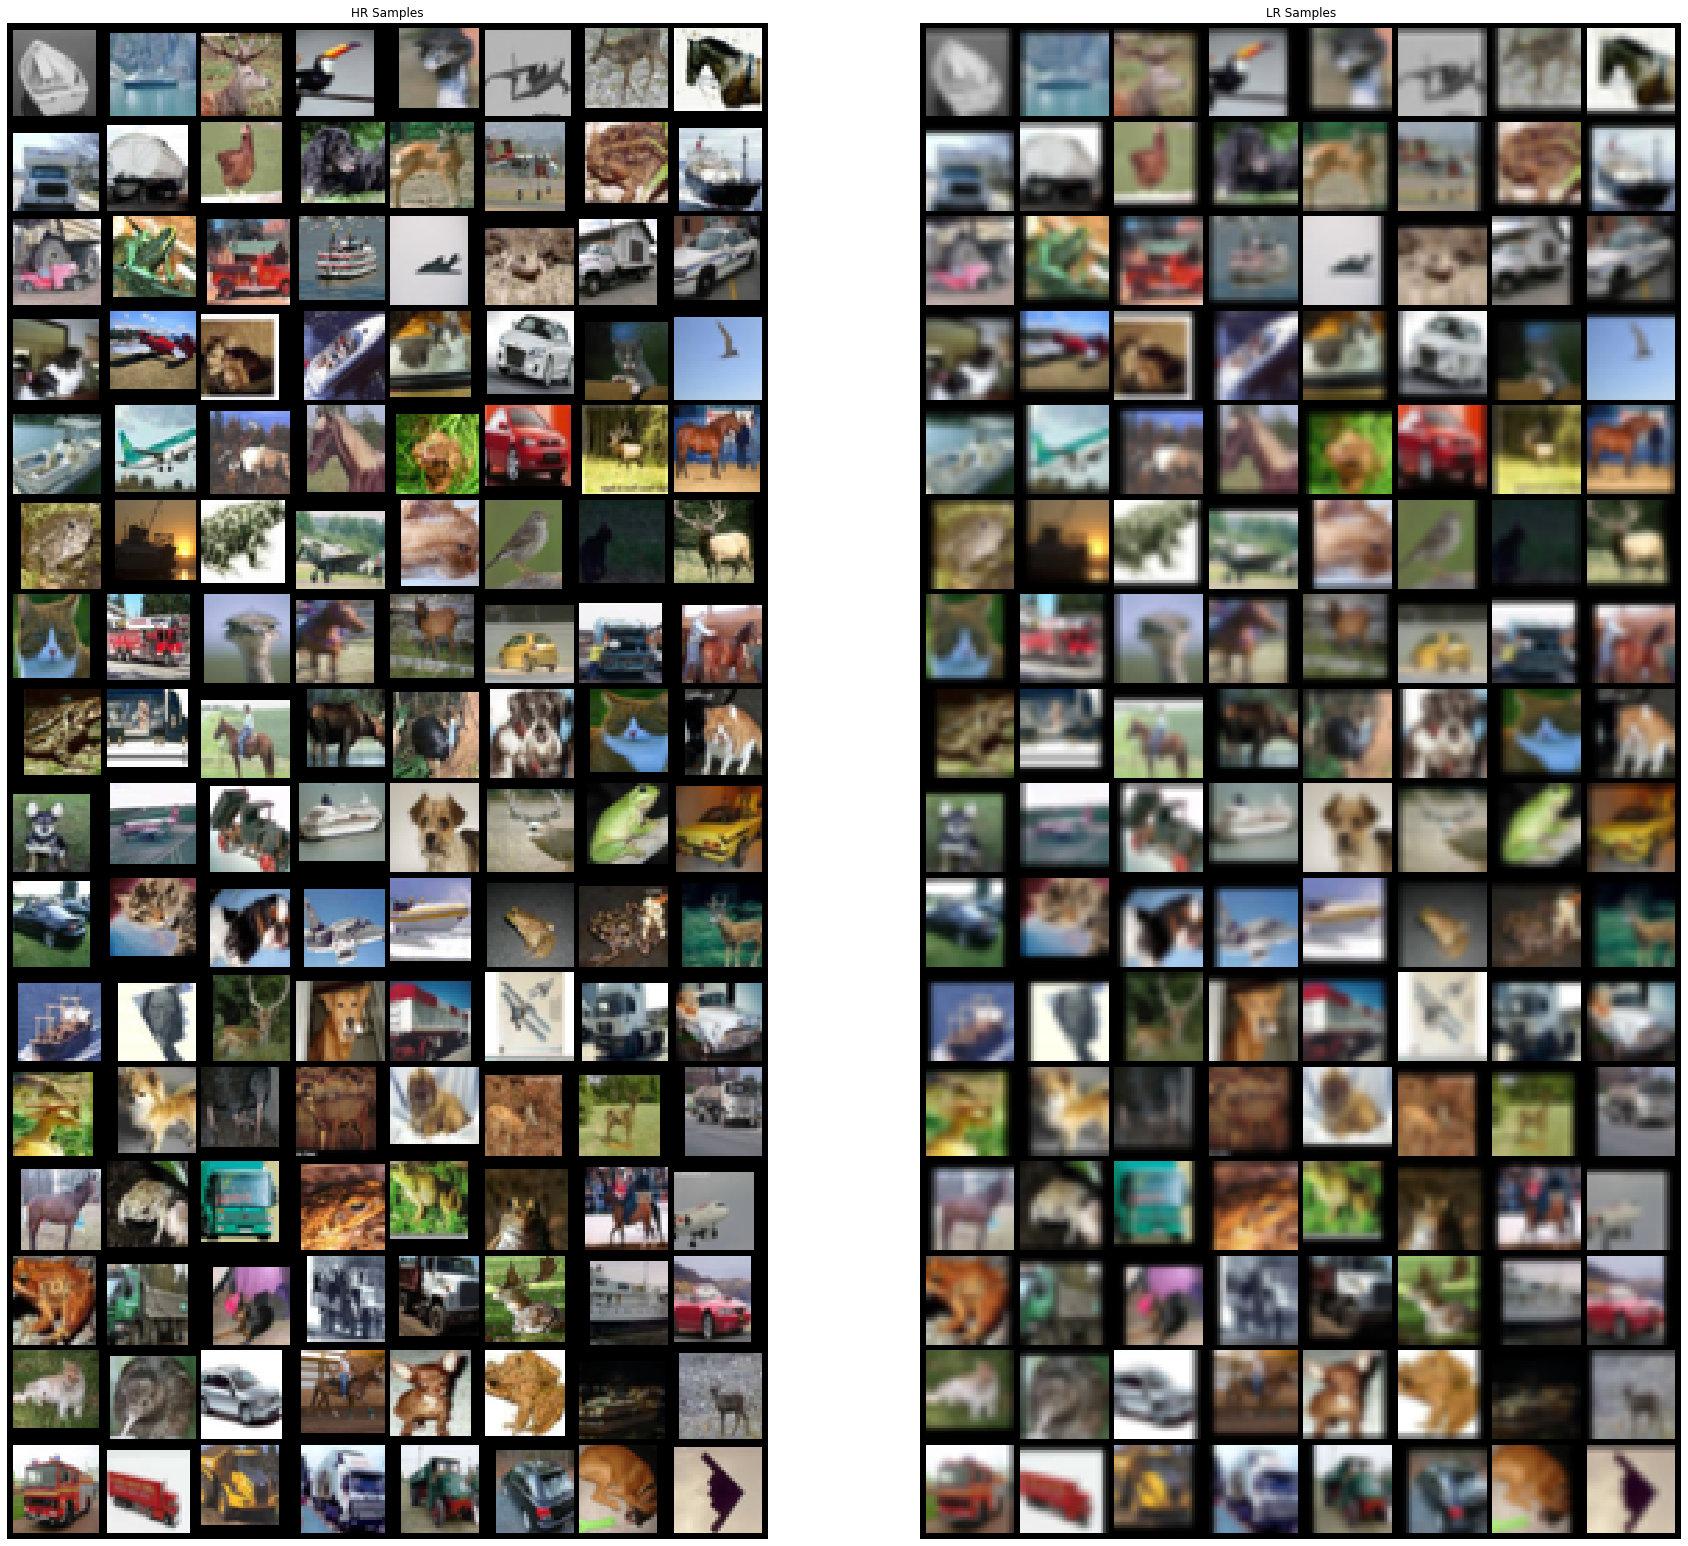

torch.Size([128, 3, 32, 32]) torch.Size([128, 3, 32, 32]) torch.Size([128])


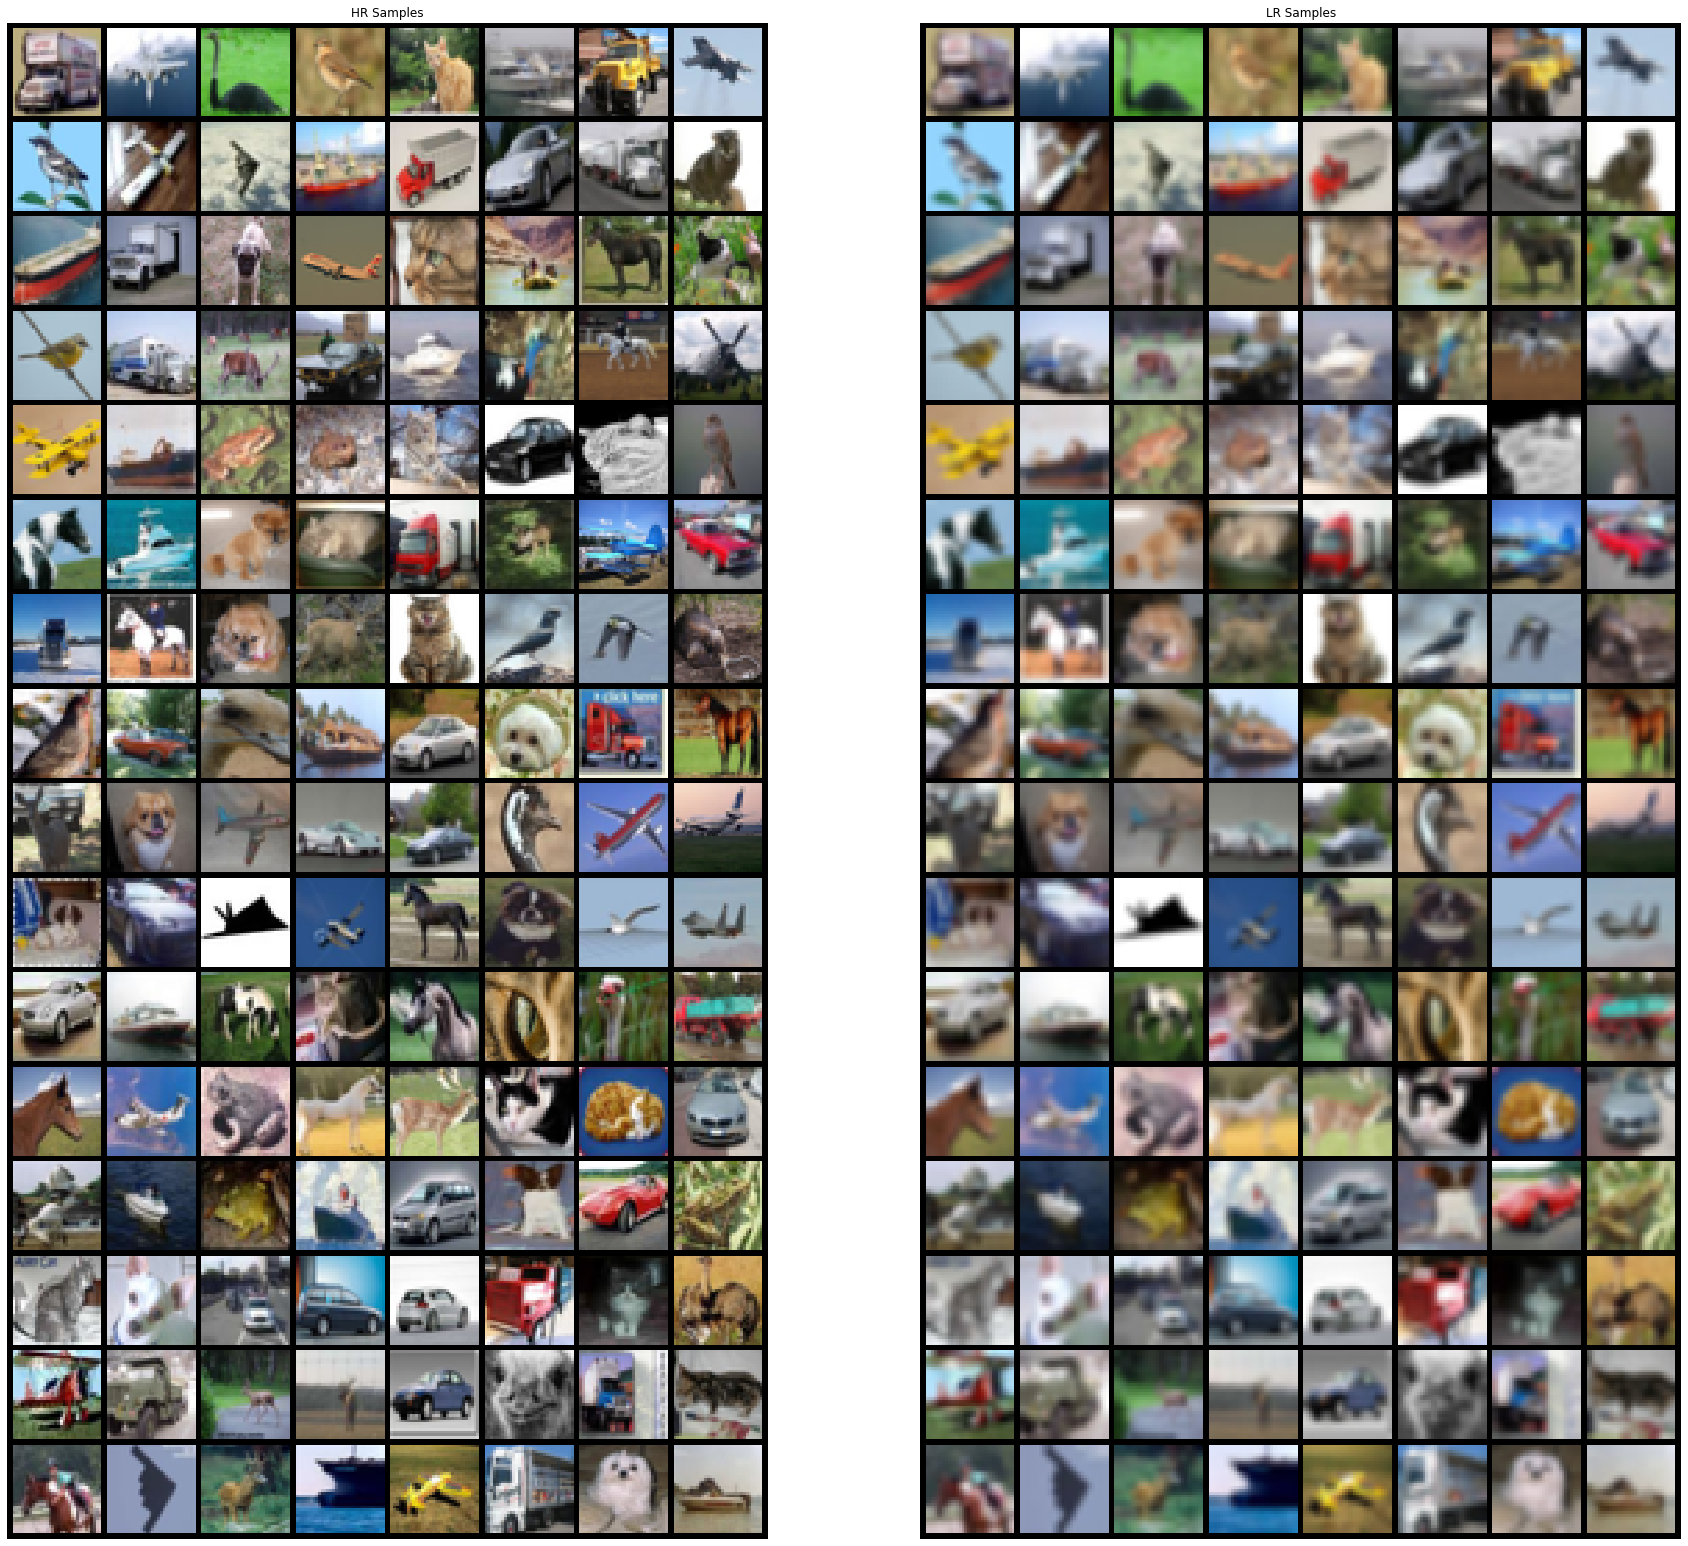

In [40]:
for data in train_loader:
    LR, HR, label = data[0], data[1], data[2]
    print(HR.shape, LR.shape, label.shape)
    
    fig, ax = plt.subplots(1,2)
    
    LR_samples = make_grid(LR, nrow=8).permute(1,2,0)
    HR_samples = make_grid(HR, nrow=8).permute(1,2,0)
    ax[0].imshow(HR_samples)
    ax[0].axis('off')
    ax[0].set_title('HR Samples')
    ax[1].imshow(LR_samples)
    ax[1].axis('off')
    ax[1].set_title('LR Samples')
    plt.show()
    break
    
for data in test_loader:
    LR, HR, label = data[0], data[1], data[2]
    print(HR.shape, LR.shape, label.shape)
    
    fig, ax = plt.subplots(1,2)
    
    LR_samples = make_grid(LR, nrow=8).permute(1,2,0)
    HR_samples = make_grid(HR, nrow=8).permute(1,2,0)
    ax[0].imshow(HR_samples)
    ax[0].axis('off')
    ax[0].set_title('HR Samples')
    ax[1].imshow(LR_samples)
    ax[1].axis('off')
    ax[1].set_title('LR Samples')
    plt.show()
    break

In [41]:
def get_model(model, down_scale=2, pretrained=False, num_classes = 18):
    if model == 'resnet50':
        if down_scale == 1:
            net = models.resnet50(pretrained=pretrained)
        else:
            net = lrResnet.resnet50_LR(scale=down_scale, pretrained=pretrained)
        net.fc = nn.Linear(in_features=2048, out_features=num_classes)
    elif model == 'resnet34':
        if down_scale == 1:
            net = models.resnet34(pretrained=pretrained)
        else:
            net = lrResnet.resnet34_LR(scale=down_scale, pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
        
    elif model == 'resnet18':
        if down_scale == 1:
            net = models.resnet18(pretrained=pretrained)
        else:
            net = lrResnet.resnet18_LR(scale=down_scale, pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
    return net

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_name = "CIFAR10"

teacher_name = 'resnet18'
student_name = 'resnet18'
print(f"Teacher: {teacher_name}, Student: {student_name}")

net_t = get_model(teacher_name, 8, pretrained=True, num_classes=10)
net_t = net_t.to(device)
teacher_dict = torch.load(f"./models/{data_name}/best_{teacher_name}_x8_True.pth")

net_t.load_state_dict(teacher_dict['net'])

# DFD uses same scale model for the student (Interpolated Input)
net_s = get_model(student_name, 8, pretrained=True, num_classes=10) 
net_s = net_s.to(device)
# student_dict = torch.load(f"./models/birds/best_resnet18_x{down_scale}_True.pth")

print(f"Distillate teacher's HR(x1) knowledge ({teacher_dict['acc']*100:.2f}%) to the student.")
# print(f"Using pretrained student's LR(x2) knowledge ({student_dict['acc']*100:.2f}%) to the student.")

Teacher: resnet18, Student: resnet18
Distillate teacher's HR(x1) knowledge (91.00%) to the student.


In [43]:
# For multiple GPU support
net_t = nn.DataParallel(net_t)
net_s = nn.DataParallel(net_s)

# New loss function between LR and HR representation
1. Fitting the feature map size 
    - Teacher(1x) : 224 -> (MaxPool) -> 112 -> 56 -> 28 -> 14 -> 7 GAP
    - Student (Smaller ResNets)
        - Ch  : 3   -> 64  -> 64  -> 128 -> 256 -> 512 
        - 2x  : 112 -> 112 -> 56  -> 28  -> 14  -> 7   -> GAP
        - 4x  : 56  -> 56  -> 28  -> 14  -> 7   -> 7   -> GAP
        - 8x  : 28  -> 28  -> 14  -> 14  -> 7   -> 7   -> GAP

In [44]:
# -------- Attention Loss between Teacher & Student ------------ #

feature_teacher = None # Updated when 'net_t.forward()' called
feature_student = None # Updated when 'net_s.forward()' called

def feature_hook_t(self, input, output):
    feature_teacher = output
    
def feature_hook_s(self, input, output):
    feature_student = output

net_s.module.layer1.register_forward_hook(feature_hook_t)
net_t.module.layer1.register_forward_hook(feature_hook_s)

criterion_att = nn.MSELoss()

if feature_teacher != None and feature_student != None:
    loss_att = criterion_att(feature_teacher, feature_student)
else:
    assert 'Features are not updated yet !'

In [45]:
class KD_loss():
    def __init__(self, params):
        self.fn = nn.KLDivLoss()
        self.alpha = params['alpha']
        self.T = params['T']
    def __call__(self, student_outputs, teacher_outputs):
        return self.fn(F.log_softmax(student_outputs/self.T, dim=1),
                             F.softmax(teacher_outputs/self.T, dim=1)) * (self.alpha * self.T * self.T)

def distillate(teacher, student, train_loader):
    params = {'alpha':0.7, 'T':30}

    # param_lambda = 2
    
    criterion_CEL = nn.CrossEntropyLoss()

    # According to 'Low-resolution visual recognition via deep feature distillation(DFD)',
    # They use MSE Loss for distillation loss instead of NLL loss.

    criterion_KLD = KD_loss(params)
    # criterion_KLD = nn.MSELoss() 
    
    
    # DFD uses SGD with momentum 0.9, weight deacy 5e-4.
    optimizer = optim.SGD(student.parameters(),lr=1e-3, momentum=0.9, weight_decay=5e-4)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)
    
    train_avg_loss = 0
    n_count = 0
    n_corrects = 0

    teacher.eval()
    teacher.requires_grad = False
    student.train()

    for i, data in enumerate(train_loader):
        batch_lr, batch_hr, label = data[0].to(device), data[1].to(device), data[2].to(device) 

        optimizer.zero_grad()

        pred_t = teacher(batch_hr)
        pred_s = student(batch_lr)

        soft_loss = criterion_KLD(pred_s, pred_t)
        data_loss = criterion_CEL(pred_s, label)
    
        loss = params['alpha']*soft_loss + (1.-params['alpha'])*data_loss
        # loss = soft_loss + param_lambda*data_loss
        train_avg_loss += loss

        n_corrects += torch.sum(torch.argmax(pred_s, dim=1) == label).item()
        n_count += label.shape[0]

        loss.backward()
        optimizer.step()
        
        if(i == len(train_loader)-1):
            print(f"Soft loss = {soft_loss:.4f}, Hard loss = {data_loss:.4f}")

    train_accuracy = n_corrects/n_count
    train_avg_loss /= n_count

    return train_accuracy, train_avg_loss, student

In [46]:
def evaluate(net, test_loader, eval_target='LR'):
    net.eval()
    
    n_count = 0
    n_corrects = 0
    
    if eval_target=='LR':
        target = 0
    else:
        target = 1

    for j, data in enumerate(test_loader):
        batch, label = data[target].to(device), data[2].to(device)

        pred = net(batch)

        n_corrects += torch.sum(torch.argmax(pred, dim=1) == label).item()
        n_count += label.shape[0]

    test_accuracy = n_corrects/n_count
    
    return test_accuracy, net

In [47]:
def train_and_eval(teacher, student, epochs, train_loader, test_loader, save_name='default.pth'):
    print("─── Start Training & Evalutation ───")
    
    best_accuracy = 0
    best_model = None
    
    for i in range(epochs):
        time_start = time.time()
        print(f"┌ Epoch ({i}/{epochs-1})")
        
        train_acc, loss, student = distillate(teacher, student, train_loader)
        print(f"├── Training Loss : {loss:.4f}")
        print(f'├── Training accuracy : {train_acc*100:.2f}%')
        print("│ Testing ...")
        test_acc, student = evaluate(student, test_loader, eval_target='LR')
        print(f'└── Testing accuracy : {test_acc*100:.2f}%')
        
        if test_acc > best_accuracy:
            print(f"  └──> Saving the best model to \"{save_name}\"")
            best_accuracy = test_acc
            best_model = student
            model_dict = {'acc':best_accuracy, 'net':best_model}
            torch.save(model_dict, save_name)
            
        time_end = time.time()
            
        epoch_time = time_end - time_start
        epoch_time_gm = time.gmtime(epoch_time)
        estimated_time = epoch_time * (epochs - 1 - i)
        estimated_time_gm = time.gmtime(estimated_time)
        print(f"Epoch time ─ {epoch_time_gm.tm_hour}[h] {epoch_time_gm.tm_min}[m] {epoch_time_gm.tm_sec}[s]")
        print(f"Estimated time ─ {estimated_time_gm.tm_hour}[h] {estimated_time_gm.tm_min}[m] {estimated_time_gm.tm_sec}[s]")   
        print("\n")
            
    return best_accuracy, best_model
        
epochs = 200
accuracy, net_t = train_and_eval(net_t, net_s, epochs, train_loader, test_loader, save_name=f"./models/distillate/T{teacher_name}_S{student_name}_x{LR_scale}.pth")
# ex : Tresnet34_Sresnet18_x2.pth

0[h] 0[m] 29[s]
Estimated time ─ 0[h] 43[m] 19[s]


┌ Epoch (113/199)
Soft loss = 0.2128, Hard loss = 0.1639
├── Training Loss : 0.0016
├── Training accuracy : 97.42%
│ Testing ...
└── Testing accuracy : 87.05%
Epoch time ─ 0[h] 0[m] 29[s]
Estimated time ─ 0[h] 42[m] 49[s]


┌ Epoch (114/199)
Soft loss = 0.2102, Hard loss = 0.2358
├── Training Loss : 0.0016
├── Training accuracy : 97.31%
│ Testing ...
└── Testing accuracy : 86.92%
Epoch time ─ 0[h] 0[m] 29[s]
Estimated time ─ 0[h] 42[m] 18[s]


┌ Epoch (115/199)
Soft loss = 0.1905, Hard loss = 0.3006
├── Training Loss : 0.0016
├── Training accuracy : 97.33%
│ Testing ...
└── Testing accuracy : 86.80%
Epoch time ─ 0[h] 0[m] 29[s]
Estimated time ─ 0[h] 41[m] 52[s]


┌ Epoch (116/199)
Soft loss = 0.1998, Hard loss = 0.1938
├── Training Loss : 0.0015
├── Training accuracy : 97.52%
│ Testing ...
└── Testing accuracy : 86.60%
Epoch time ─ 0[h] 0[m] 29[s]
Estimated time ─ 0[h] 41[m] 21[s]


┌ Epoch (117/199)
Soft loss = 0.1973, Hard loss = 0.

### Experiments
## 1. DataParallel efficiency
- ResNet50(x1) -> ResNet18(x2) 기준 (img_sz=224, BS=64, epochs=150, num_workers=8)
    - Target Volatile GPU utilization : 80~90%
    - Single : 133 sec/epoch (5h 32m)
    - Double : 106 sec/epoch (4h 24m)
    - Quad : 92 sec/epoch (3h 50m)
    - Quad+ (BS=128) : 62 sec/epoch (2h 36m)
    - Quad++ (BS=256) : 52 sec/epoch (2h 9m)
## 2. Classification Performance
- ILSVRC Birds
    - ResNet18(x1) ---Distillate--> ResNet18(x4)
    - x1 에서 정확도 92.67%, x4 에서 87.22%
    - 정확도 87.22% 보다 높게 나오면 성공 !
    - MSE Loss vs KLdiv Loss
- CIFAR-10
    - DFD 조건대로 하면 Computation Reduction 효과 적음... (Interpolated Input)
    - 16x16 또는 8x8 이미지가 LR 이 됨. (실제 크기는 32x32)